In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

from torchmetrics import JaccardIndex, Accuracy

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

c:\Users\anthonyedge\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.5.0+cu118
Torchvision version: 0.20.0+cu118


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_CLASSES = 3 
IMG_SIZE = (128, 128)
NUM_EPOCHS = 15 
LEARNING_RATE = 0.001
SUBSET_SIZE = 1200
MODEL_SAVE_PATH = "pet_segmentation_model.pth"

print(f"Usando o dispositivo: {DEVICE}")

Usando o dispositivo: cuda


In [5]:

input_transform = T.Compose([
    T.ToImage(),
    T.Resize(IMG_SIZE),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = T.Compose([
    T.ToImage(),
    T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.NEAREST),
    T.ToDtype(torch.long, scale=False),
    # Ajusta as classes de [1, 2, 3] para [0, 1, 2]
    T.Lambda(lambda x: x - 1)
])

full_train_dataset = torchvision.datasets.OxfordIIITPet(
    root=".",
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=input_transform,
    target_transform=target_transform
)

test_dataset = torchvision.datasets.OxfordIIITPet(
    root=".",
    split="test",
    target_types="segmentation",
    download=True,
    transform=input_transform,
    target_transform=target_transform
)

indices = torch.arange(SUBSET_SIZE)
subset_train_dataset = Subset(full_train_dataset, indices)

train_loader = DataLoader(subset_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Tamanho do dataset de treino completo: {len(full_train_dataset)}")
print(f"Usando um subconjunto para treino de tamanho: {len(subset_train_dataset)}")
print(f"Tamanho do dataset de teste: {len(test_dataset)}")

100%|██████████| 792M/792M [07:00<00:00, 1.88MB/s] 


Extracting oxford-iiit-pet\images.tar.gz to oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:07<00:00, 2.58MB/s]


Extracting oxford-iiit-pet\annotations.tar.gz to oxford-iiit-pet
Tamanho do dataset de treino completo: 3680
Usando um subconjunto para treino de tamanho: 1200
Tamanho do dataset de teste: 3669


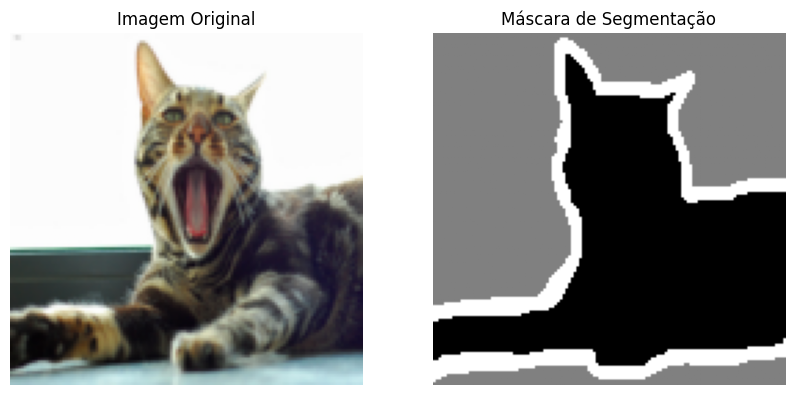

Valores únicos na máscara: tensor([0, 1, 2])


In [6]:

def imshow(tensor_img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor_img = tensor_img * std + mean
    np_img = tensor_img.numpy().transpose((1, 2, 0))
    np_img = np.clip(np_img, 0, 1)
    return np_img

images, masks = next(iter(train_loader))
img_to_show = images[0]
mask_to_show = masks[0].squeeze()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(imshow(img_to_show))
ax[0].set_title("Imagem Original")
ax[0].axis('off')

ax[1].imshow(mask_to_show, cmap='gray')
ax[1].set_title("Máscara de Segmentação")
ax[1].axis('off')

plt.show()

print(f"Valores únicos na máscara: {torch.unique(mask_to_show)}")

In [7]:
model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)

model.classifier[4] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))

model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\anthonyedge/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:29<00:00, 4.86MB/s] 


In [9]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.squeeze(1).to(DEVICE)

        optimizer.zero_grad()

        outputs = model(images)['out']

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Época [{epoch+1}/{NUM_EPOCHS}], Perda: {epoch_loss:.4f}")

print("\nTreinamento Concluído!")

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Modelo salvo em: {MODEL_SAVE_PATH}")

Época [1/15], Perda: 0.4985
Época [2/15], Perda: 0.3736
Época [3/15], Perda: 0.3313
Época [4/15], Perda: 0.2844
Época [5/15], Perda: 0.2733
Época [6/15], Perda: 0.2456
Época [7/15], Perda: 0.2359
Época [8/15], Perda: 0.2227
Época [9/15], Perda: 0.2391
Época [10/15], Perda: 0.2044
Época [11/15], Perda: 0.1932
Época [12/15], Perda: 0.1810
Época [13/15], Perda: 0.1635
Época [14/15], Perda: 0.1832
Época [15/15], Perda: 0.1559

Treinamento Concluído!
Modelo salvo em: pet_segmentation_model.pth


In [10]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

model.eval()

iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)


with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(DEVICE)
        masks = masks.squeeze(1).to(DEVICE)

        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)

        iou_metric.update(preds, masks)
        accuracy_metric.update(preds, masks)
        
total_iou = iou_metric.compute()
total_accuracy = accuracy_metric.compute()

print(f"\n--- Resultados da Avaliação no Dataset de Teste ---")
print(f"IoU (Jaccard Index): {total_iou:.4f}")
print(f"Acurácia de Pixel: {total_accuracy:.4f}")

C:\Users\anthonyedge\AppData\Local\Temp\ipykernel_18196\3884669925.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))



--- Resultados da Avaliação no Dataset de Teste ---
IoU (Jaccard Index): 0.7207
Acurácia de Pixel: 0.8928


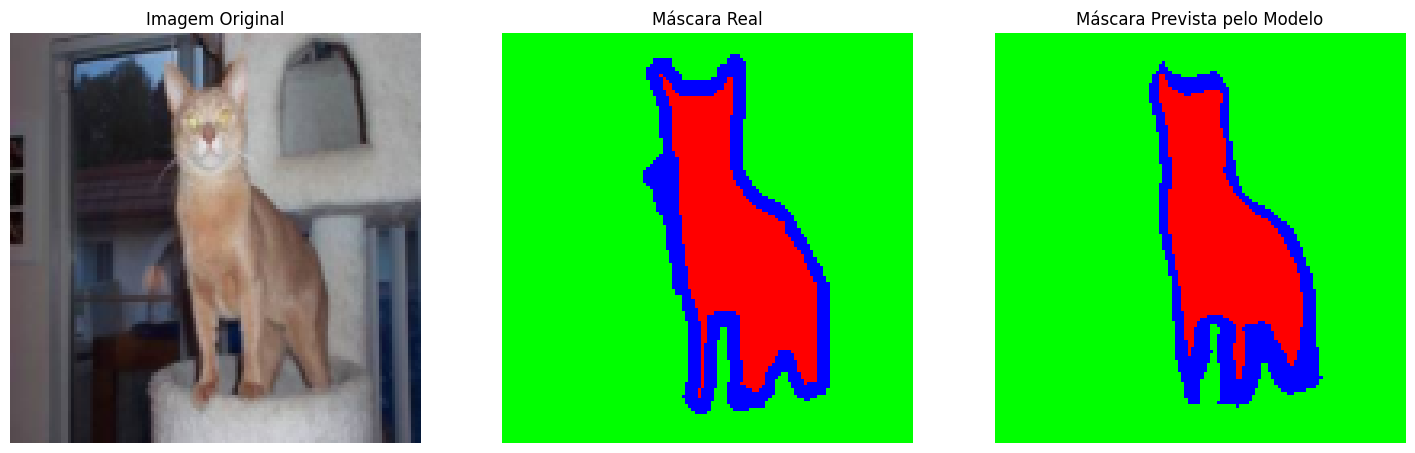

In [12]:
colors = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]], dtype=torch.uint8)

def colorize_mask(mask_tensor, colors):
    h, w = mask_tensor.shape
    colored_mask = torch.zeros(h, w, 3, dtype=torch.uint8)
    for class_idx in range(len(colors)):
        colored_mask[mask_tensor == class_idx] = colors[class_idx]
    return colored_mask.numpy()


images, masks = next(iter(test_loader))
images, masks = images.to(DEVICE), masks.to(DEVICE)

model.eval()
with torch.no_grad():
    output = model(images)['out']
    preds = torch.argmax(output, dim=1)

idx_to_show = 1
image_np = imshow(images[idx_to_show].cpu())
true_mask_np = colorize_mask(masks[idx_to_show].squeeze().cpu(), colors)
pred_mask_np = colorize_mask(preds[idx_to_show].cpu(), colors)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(image_np)
ax[0].set_title("Imagem Original")
ax[0].axis('off')

ax[1].imshow(true_mask_np)
ax[1].set_title("Máscara Real")
ax[1].axis('off')

ax[2].imshow(pred_mask_np)
ax[2].set_title("Máscara Prevista pelo Modelo")
ax[2].axis('off')

plt.show()